# rule based feature 추출

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Cathode

In [2]:
Cathode_Normal = sorted([x for x in Path("../data/230507/Cathode/Normal").glob("*.csv")])
Cathode_Normal

[PosixPath('../data/230507/Cathode/Normal/20230330_134146_0__02_Total.csv'),
 PosixPath('../data/230507/Cathode/Normal/48.csv'),
 PosixPath('../data/230507/Cathode/Normal/49.csv'),
 PosixPath('../data/230507/Cathode/Normal/50.csv'),
 PosixPath('../data/230507/Cathode/Normal/51.csv'),
 PosixPath('../data/230507/Cathode/Normal/52.csv'),
 PosixPath('../data/230507/Cathode/Normal/53.csv'),
 PosixPath('../data/230507/Cathode/Normal/54.csv'),
 PosixPath('../data/230507/Cathode/Normal/55.csv'),
 PosixPath('../data/230507/Cathode/Normal/56.csv'),
 PosixPath('../data/230507/Cathode/Normal/58.csv'),
 PosixPath('../data/230507/Cathode/Normal/59.csv'),
 PosixPath('../data/230507/Cathode/Normal/61.csv'),
 PosixPath('../data/230507/Cathode/Normal/62.csv'),
 PosixPath('../data/230507/Cathode/Normal/63.csv'),
 PosixPath('../data/230507/Cathode/Normal/64.csv'),
 PosixPath('../data/230507/Cathode/Normal/65.csv'),
 PosixPath('../data/230507/Cathode/Normal/67.csv'),
 PosixPath('../data/230507/Cathode/Norm

In [3]:
len(Cathode_Normal)

31

In [4]:
Cathode_Abnormal = sorted([x for x in Path("../data/230507/Cathode/Abnormal").glob("*.csv")])
Cathode_Abnormal

[PosixPath('../data/230507/Cathode/Abnormal/20230330_134728_0__03_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_134935_0__04_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135219_0__05_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135426_0__06_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140214_0__07_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140723_0__08_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140937_0__09_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141439_0__11_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141754_0__12_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142019_0__13_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142247_0__14_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142807_0__16_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330

In [5]:
len(Cathode_Abnormal)

17

In [6]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [7]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Train, Test 생성

In [8]:
Cathode_Normal_df = pd.DataFrame()
for i, c in enumerate(Cathode_Normal):
    extractor = ExtractFeatures(str(c))
    extracted_data = extractor.extract(extractor.data, degree=0.2, verbose=False)
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 0 } 
                       for d in extracted_data ]
    Cathode_Normal_df = pd.concat([Cathode_Normal_df, pd.DataFrame(extracted_data_)])

warning index: 59479
error index: 59578
warning index: 60128
error index: 60227
warning index: 60777
error index: 60876
warning index: 61427
error index: 61526
warning index: 62076
error index: 62175
warning index: 62725
error index: 62824
warning index: 63374
error index: 63473
warning index: 64022
error index: 64121
warning index: 64671
error index: 64770
warning index: 65321
error index: 65420
warning index: 65970
error index: 66069
warning index: 66619
error index: 66718
warning index: 67268
error index: 67367
warning index: 67917
error index: 68016
warning index: 68567
error index: 68666
warning index: 69216
error index: 69315
warning index: 69865
error index: 69964
warning index: 70514
error index: 70613
warning index: 71163
error index: 71262
warning index: 71813
error index: 71912
warning index: 72462
error index: 72561
warning index: 73111
error index: 73210
warning index: 73760
error index: 73859
warning index: 74409
error index: 74508
warning index: 75058
error index: 75157


In [9]:
Cathode_Abnormal_df = pd.DataFrame()
for i, c in enumerate(Cathode_Abnormal):
    extractor = ExtractFeatures(str(c))
    extracted_data = extractor.extract(extractor.data, degree=0.2, verbose=False)
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 1 } 
                       for d in extracted_data ]
    Cathode_Abnormal_df = pd.concat([Cathode_Abnormal_df, pd.DataFrame(extracted_data_)])

warning index: 43779
error index: 43877
error index: 43878
warning index: 44328
error index: 44426
warning index: 44877
error index: 44975
warning index: 45427
error index: 45525
warning index: 45976
error index: 46074
warning index: 46525
error index: 46623
warning index: 47073
warning index: 47074
error index: 47172
warning index: 47622
warning index: 47623
error index: 47721
warning index: 48171
warning index: 48172
error index: 48270
warning index: 48721
warning index: 48722
error index: 48820
warning index: 49270
warning index: 49271
error index: 49369
warning index: 49819
warning index: 49820
error index: 49918
warning index: 50369
error index: 50467
warning index: 50917
warning index: 50918
error index: 51016
warning index: 51468
error index: 51566
warning index: 52016
warning index: 52017
error index: 52115
warning index: 52565
warning index: 52566
error index: 52664
warning index: 53114
error index: 53213
warning index: 53663
warning index: 53664
error index: 53762
warning ind

In [10]:
split_rate = 0.8
train_index = int(len(Cathode_Normal)*split_rate) * 54
Cathode_Train = Cathode_Normal_df.iloc[:train_index]
Cathode_Test = pd.concat([Cathode_Normal_df.iloc[train_index:], Cathode_Abnormal_df])

In [11]:
Cathode_Train.head(5)

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,4.019588,3.660666,4.087526,0.056035,100,395.425955,9.666011,19,7.855454,0.110699,...,0.0,0,0.000000,5.628348,0.081124,35,0.0,1,0.043257,0
1,4.030147,3.701381,4.080741,0.038418,100,396.526873,9.687985,18,8.088445,0.099042,...,0.0,-1,0.000000,5.645447,0.079182,29,0.0,1,0.037755,0
2,4.032917,3.673592,4.083326,0.042525,100,396.520407,9.709959,19,8.025430,0.123004,...,0.0,1,0.037518,5.513527,0.113165,41,0.0,-1,0.000000,0
3,4.031362,3.711399,4.090112,0.040109,100,396.456110,9.689277,19,7.983097,0.114261,...,0.0,2,0.080865,5.519487,0.108634,40,0.0,2,0.138622,0
4,4.032664,3.711722,4.091404,0.040317,100,396.540771,9.699941,20,7.442467,0.122356,...,0.0,3,0.133602,5.509214,0.083713,45,0.0,2,0.152539,0


In [12]:
Cathode_Test.head(5)

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,4.034671,3.578267,4.092050,0.054884,100,396.112616,9.634665,18,7.984067,0.138871,...,0.0,1,0.047880,5.997681,0.104103,35,0.0,2,0.085868,0
1,4.036869,3.579237,4.104006,0.053730,100,396.330411,9.671181,24,7.972111,0.135956,...,0.0,2,0.093817,6.810065,0.114783,40,0.0,0,0.000000,0
2,4.035822,3.605411,4.098513,0.051436,100,396.395685,9.687338,28,7.975018,0.113937,...,0.0,1,0.039785,6.310997,0.141646,55,0.0,1,0.046494,0
3,4.034233,3.589900,4.088496,0.053367,100,396.279998,9.682168,18,8.050313,0.134337,...,0.0,2,0.090903,6.798597,0.113489,37,0.0,2,0.100432,0
4,4.034209,3.590870,4.084941,0.051651,100,396.188882,9.672474,34,7.950460,0.152795,...,0.0,6,0.303794,6.118805,0.139057,46,0.0,1,0.064618,0


### Isolation Forest

In [13]:
import seaborn as sns

class modelling:
    def __init__(self, model, dataset, feature_name : str, **kwargs):
        """
        Fit and run inference on model & Get evaluation Metrics
        :param model
            Model
        :dataset: tuple
            train and test datset
        :feature_name: str
            Name of the feature to be used
        """

        self.train_x, self.train_y, self.test_x, self.test_y = (dataset[0][feature_name].values.reshape(-1,1), 
                                                                dataset[1], 
                                                                dataset[2][[feature_name]].values.reshape(-1,1), 
                                                                dataset[3])
        self.model = model(**kwargs)

        self.threshold = None
        self.feature_name = feature_name

    def fit(self):
        """
        Fit Model
        :return: None
        """
        
        self.model.fit(self.train_x)
        
        print("model Fitted")
        
        pred = self.model.predict(self.test_x)
        self.pred = np.where(pred==1, 0, 1)
        
        self.anomaly_score = self.model.score_samples(self.test_x)

        print("Inference Completed")

    def get_confusion_mat(self):
        """
        Get confusion Matrix
        :return: tuple
            Confusion Matrix
        """

        if self.threshold:
            pred_ = self.pred_manual
        else:
            pred_ = self.pred

        tn, fp, fn, tp = confusion_matrix(self.test_y, pred_).ravel()

        self.confusion_mat = (tn, fp, fn, tp)

        print(f'Confusion Matrix: {self.confusion_mat}')

        sns.heatmap(np.array(self.confusion_mat).reshape(2,2),
                    annot = True,
                    cmap = 'Blues',
                    fmt=',d'
                    )
        
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix ' + self.feature_name)

        plt.show()

        return self.confusion_mat

    def get_metrics(self):

        """
        Get model evaluation metrics
        :return: dict
        """

        (f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-self.anomaly_score, 
                                                                  np.array(self.test_y), 
                                                                  start=min(-self.anomaly_score), 
                                                                  end=max(-self.anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
        
        print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        self.threshold = threshold
        self.pred_manual = -self.anomaly_score >= self.threshold

        metric = {
                'AUROC' : AUROC, 'F1 ' : f1,
                'Precision' : precision, 'Recall' : recall
                }

        return metric

    def bead_count(self):
        """
        Prediciton result for each beads
        :return: list
        """

        bead_counter = []
        for i in range(len(self.pred_manual)//54):
            bead_counter.append(dict(Counter(self.pred_manual[i*54: (i+1)*54])))

        print(bead_counter)

        self.bead_counter = bead_counter
        
        return bead_counter

    def plot_result(self):
        """
        Plot Anomaly Detection Prediction Result
        """

        # Test set Prediction Result

        fig = plt.figure(figsize=(12, 4))
        plt.plot(self.pred_manual, label='pred')
        plt.plot(np.array(self.test_y), label='Ground Truth')
        plt.title('Anomaly Detection Result '+ self.feature_name)
        plt.legend()
        plt.show()

        check_graph(self.pred_manual, np.array(self.test_y))
        plt.title('Anomaly Detection Result '+ self.feature_name)

        plt.show()

        # Anomaly Score with best-threshold

        if not self.threshold:
            raise NotImplementedError("Please Search best-threshold first")
        
        check_graph(-self.anomaly_score, np.array(self.test_y), threshold=self.threshold)

        plt.title('Anomaly Score with Threshold '+ self.feature_name)
        plt.show()

In [14]:
selected_features = list(Cathode_Train.columns[9:15]) + ['lo_height_mean', 'lo_area', 'br_diff_peak', 'vis_reach_time']

print(selected_features)

Cathode_Train_X = Cathode_Train[selected_features]
Cathode_Train_y = Cathode_Train['label'].reset_index(drop=True)
Cathode_Test_X = Cathode_Test[selected_features].reset_index(drop=True)
Cathode_Test_y = Cathode_Test['label']

['nir_peak', 'nir_reach_time', 'nir_over_area', 'nir_extra_time', 'nir_extra_area', 'nir_sum_area', 'lo_height_mean', 'lo_area', 'br_diff_peak', 'vis_reach_time']


In [15]:
model = IsolationForest
dataset = (Cathode_Train_X, Cathode_Train_y, 
           Cathode_Test_X, Cathode_Test_y)

nir_peak
model Fitted
Inference Completed
AUROC: 0.5940, F1: 0.8288, Precision: 0.7093, Recall: 0.9967
Confusion Matrix: (3, 375, 3, 915)


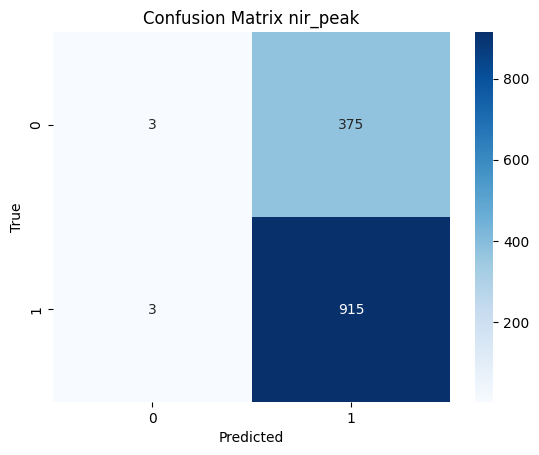

[{True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {False: 1, True: 53}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}]


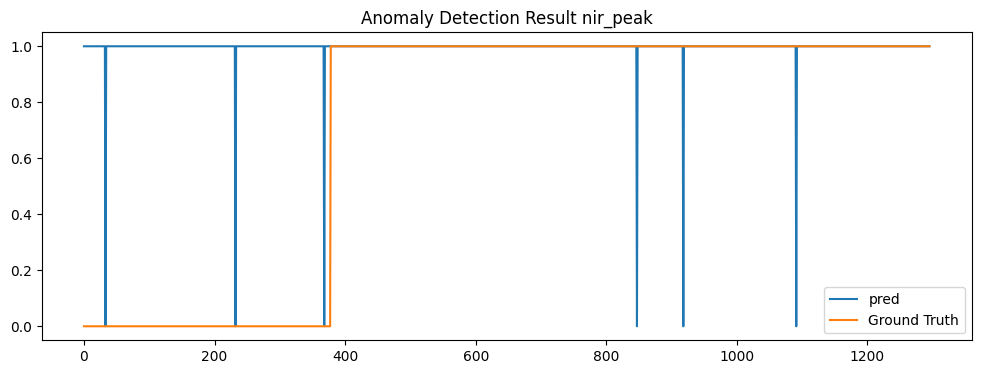

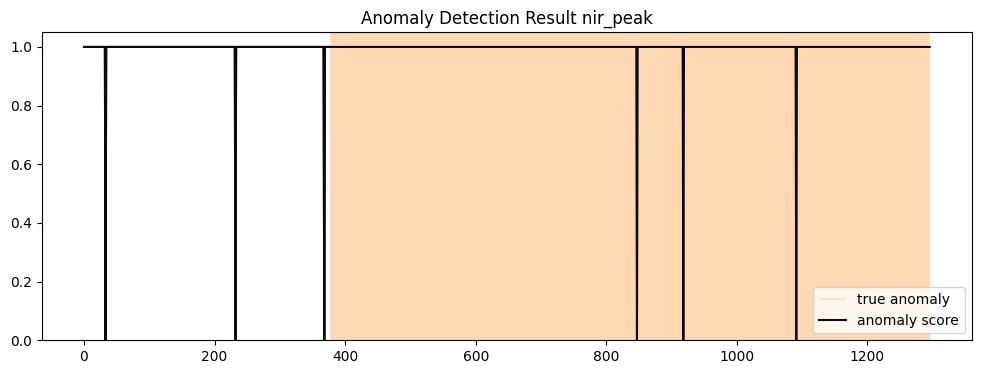

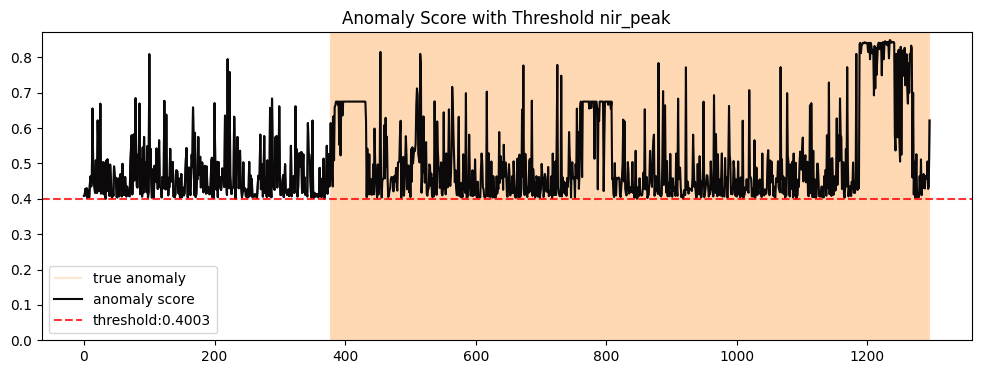

nir_reach_time
model Fitted
Inference Completed
AUROC: 0.6627, F1: 0.8225, Precision: 0.7090, Recall: 0.9793
Confusion Matrix: (9, 369, 19, 899)


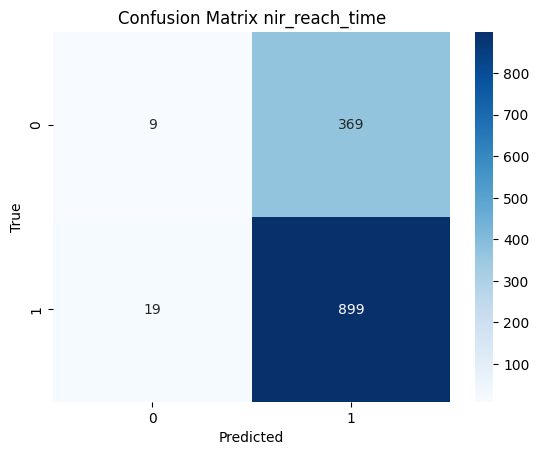

[{True: 54}, {True: 53, False: 1}, {True: 50, False: 4}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 52, False: 2}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 50, False: 4}, {True: 51, False: 3}, {True: 52, False: 2}, {True: 52, False: 2}, {True: 53, False: 1}, {True: 52, False: 2}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}]


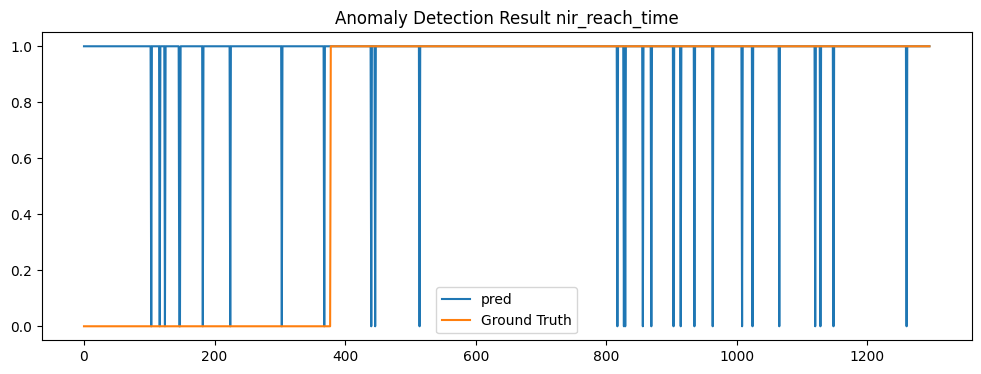

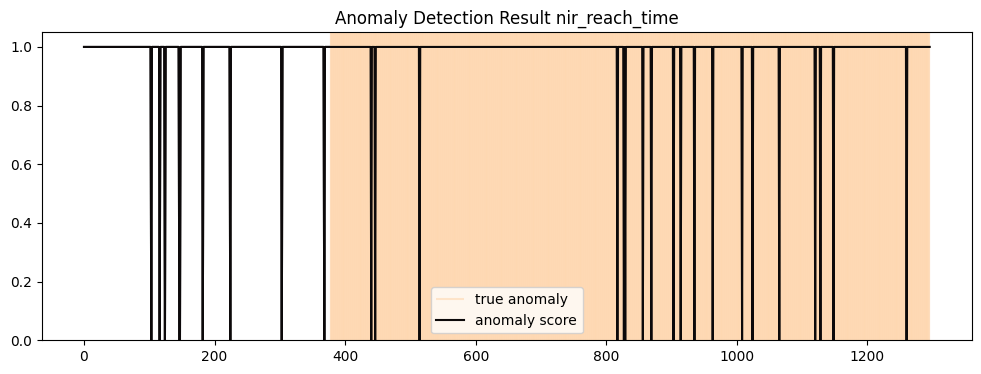

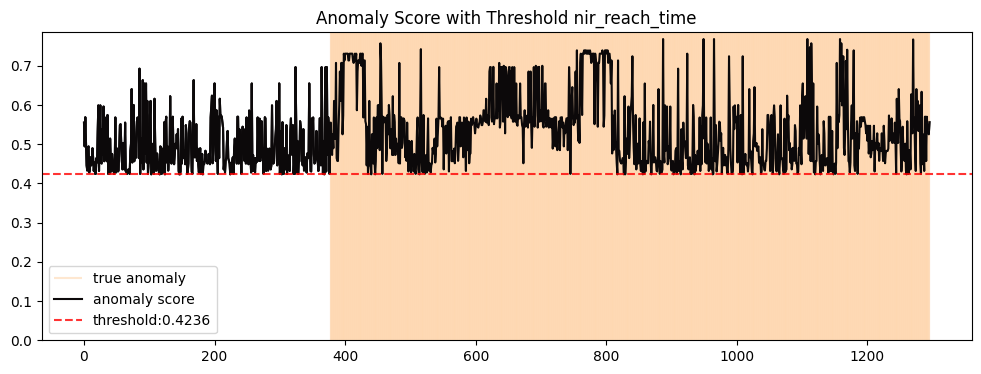

nir_over_area
model Fitted
Inference Completed
AUROC: 0.5082, F1: 0.0322, Precision: 1.0000, Recall: 0.0163
Confusion Matrix: (378, 0, 903, 15)


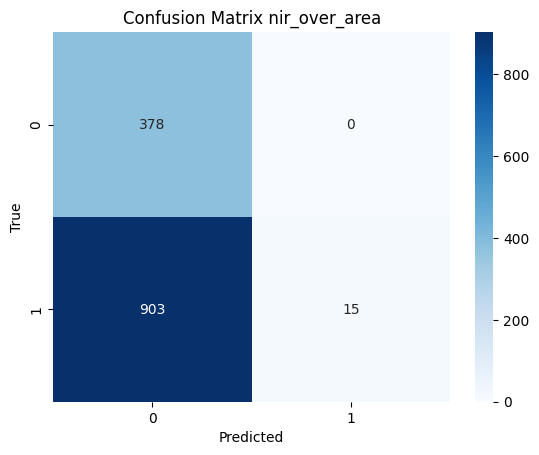

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 39, True: 15}, {False: 54}]


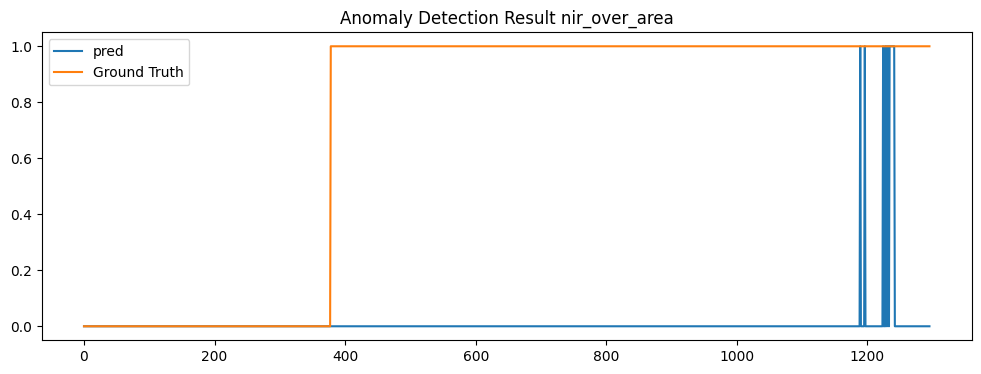

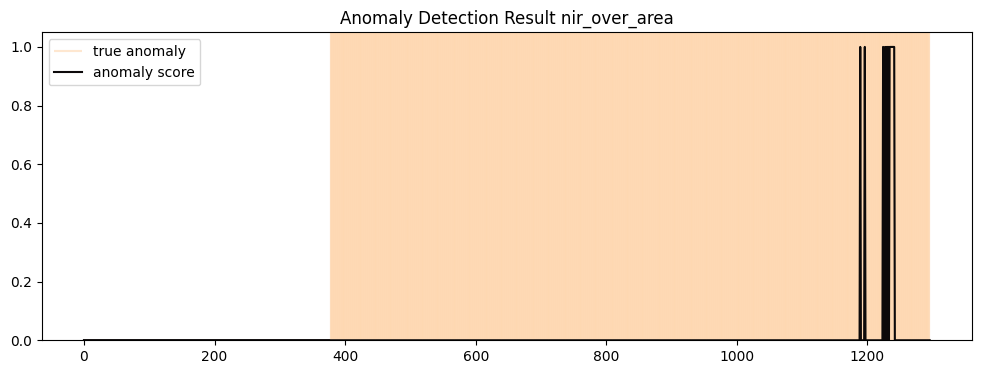

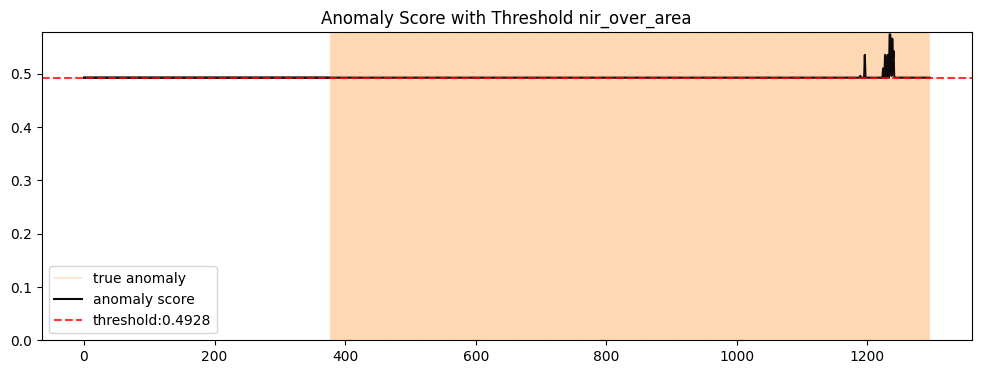

nir_extra_time
model Fitted
Inference Completed
AUROC: 0.5680, F1: 0.7821, Precision: 0.7183, Recall: 0.8584
Confusion Matrix: (69, 309, 130, 788)


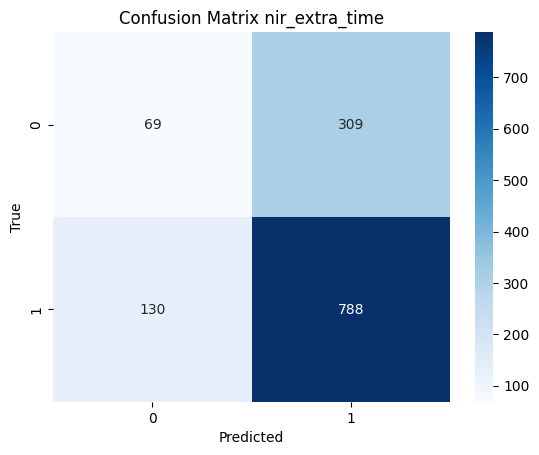

[{False: 9, True: 45}, {False: 13, True: 41}, {True: 46, False: 8}, {True: 44, False: 10}, {True: 42, False: 12}, {True: 44, False: 10}, {True: 47, False: 7}, {False: 3, True: 51}, {True: 38, False: 16}, {True: 47, False: 7}, {True: 47, False: 7}, {True: 51, False: 3}, {True: 46, False: 8}, {True: 49, False: 5}, {False: 4, True: 50}, {False: 11, True: 43}, {False: 10, True: 44}, {False: 12, True: 42}, {False: 14, True: 40}, {True: 44, False: 10}, {True: 45, False: 9}, {True: 50, False: 4}, {True: 53, False: 1}, {True: 48, False: 6}]


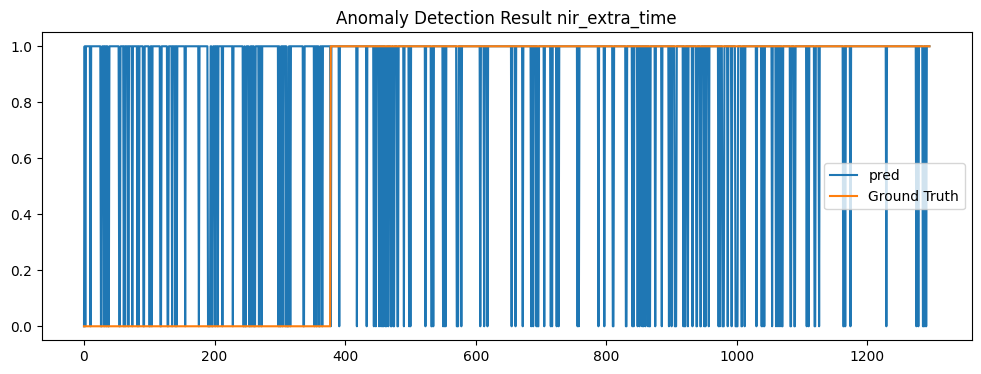

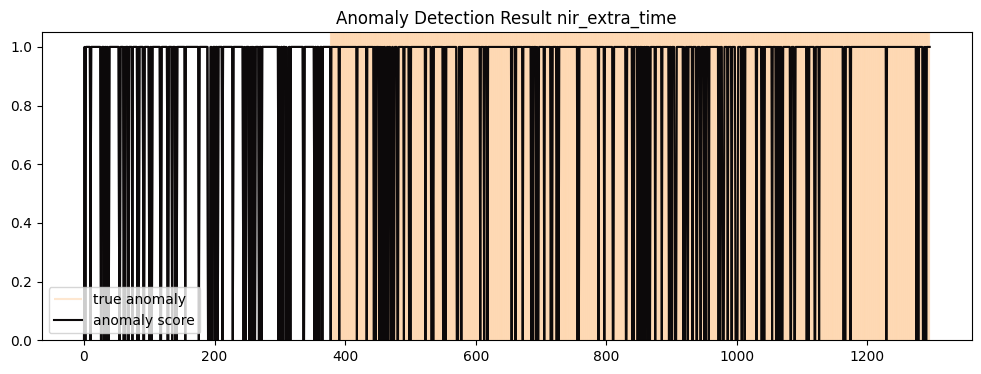

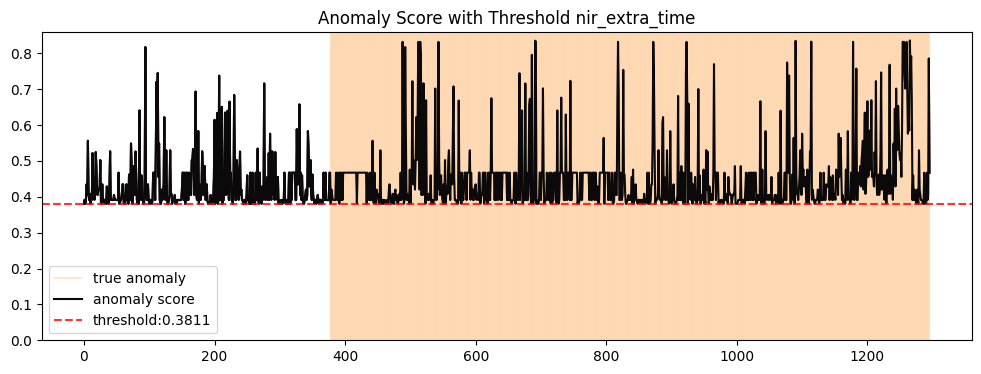

nir_extra_area
model Fitted
Inference Completed
AUROC: 0.4894, F1: 0.8260, Precision: 0.7085, Recall: 0.9902
Confusion Matrix: (4, 374, 9, 909)


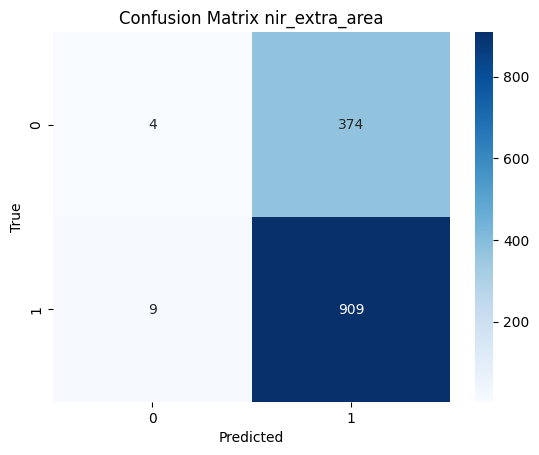

[{True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 52, False: 2}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 53, False: 1}]


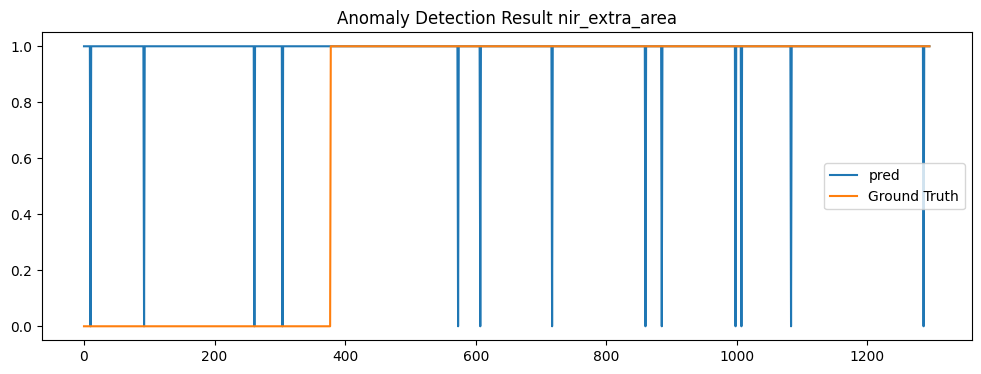

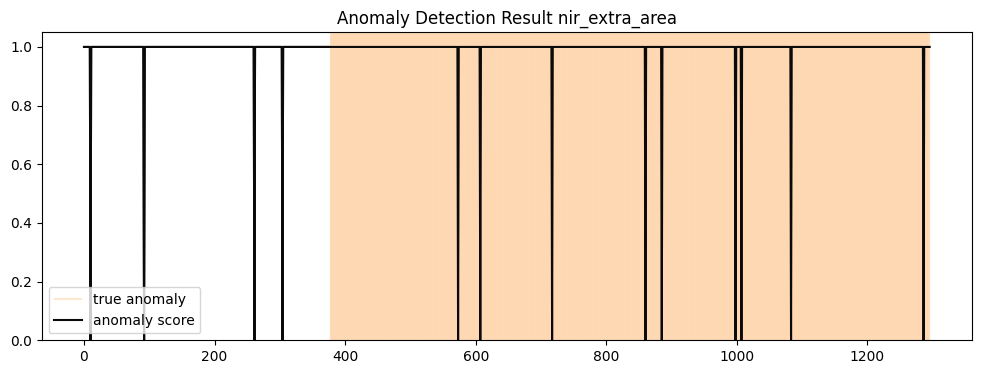

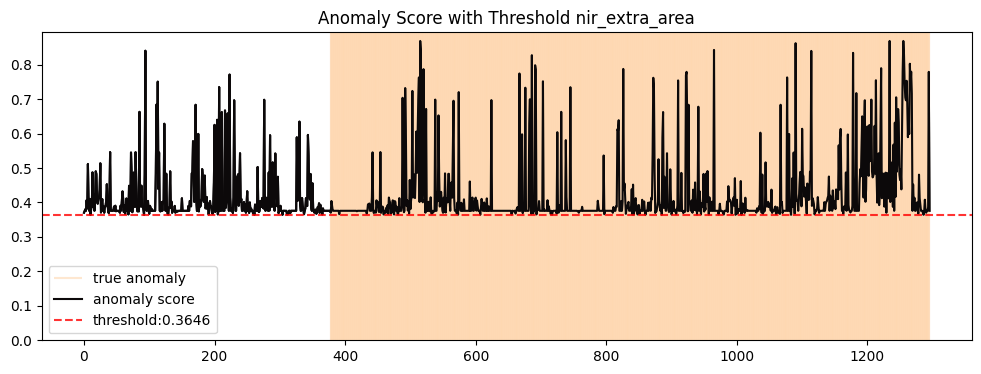

nir_sum_area
model Fitted
Inference Completed
AUROC: 0.6688, F1: 0.8312, Precision: 0.7123, Recall: 0.9978
Confusion Matrix: (8, 370, 2, 916)


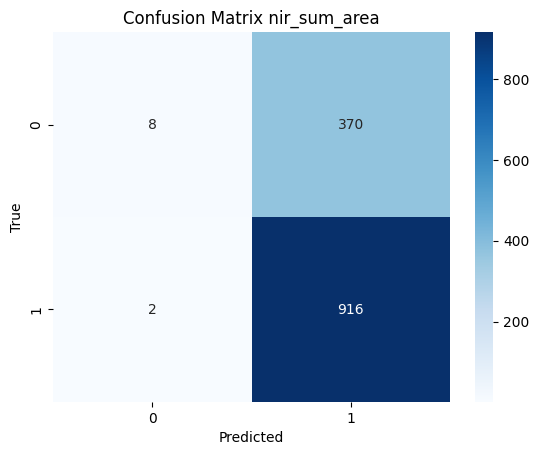

[{True: 53, False: 1}, {True: 53, False: 1}, {True: 51, False: 3}, {True: 52, False: 2}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}]


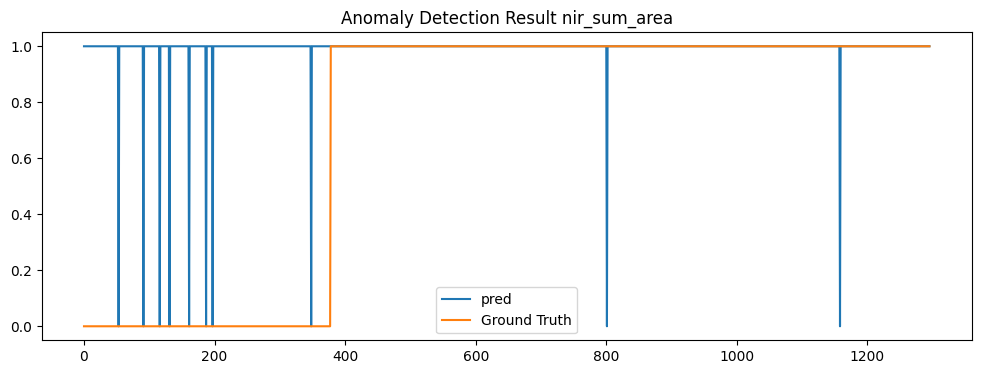

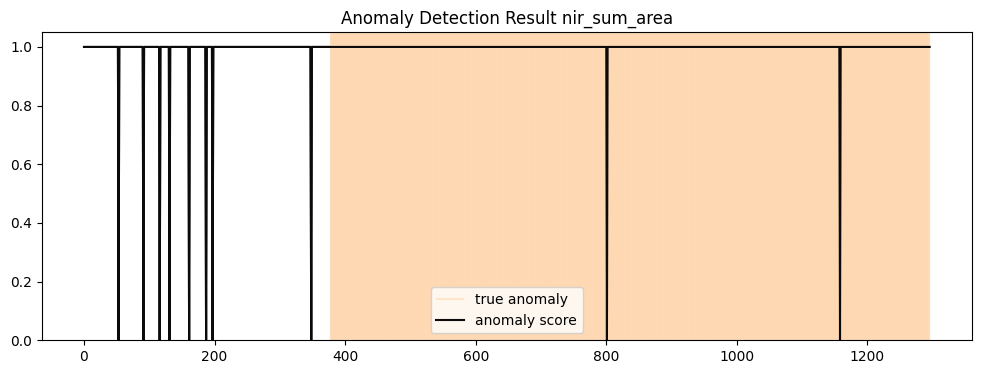

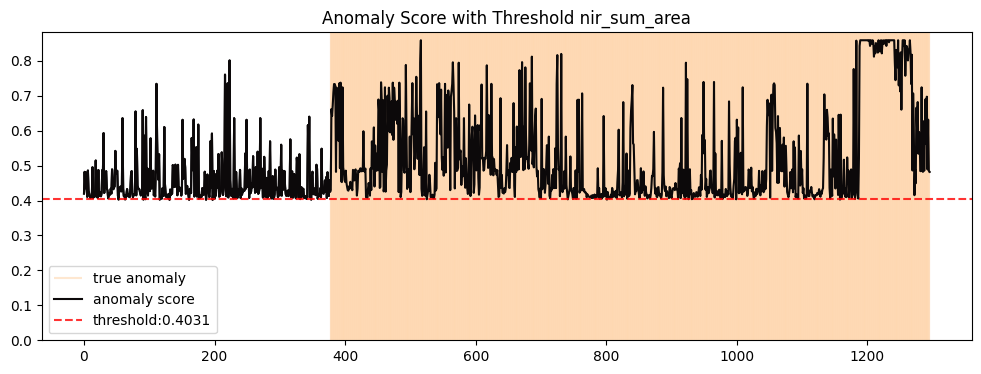

lo_height_mean
model Fitted
Inference Completed
AUROC: 0.9974, F1: 0.9935, Precision: 0.9903, Recall: 0.9967
Confusion Matrix: (369, 9, 3, 915)


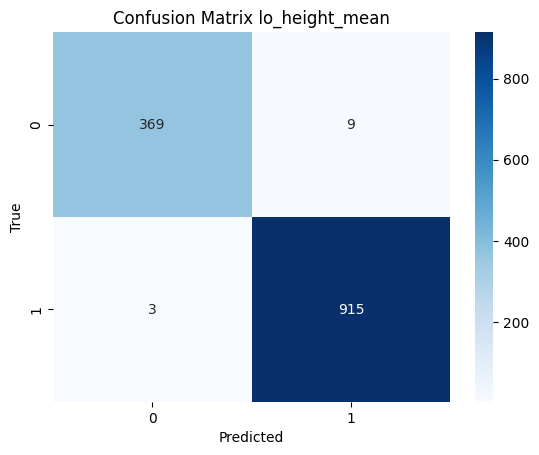

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 53, True: 1}, {False: 51, True: 3}, {False: 49, True: 5}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 51, False: 3}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}]


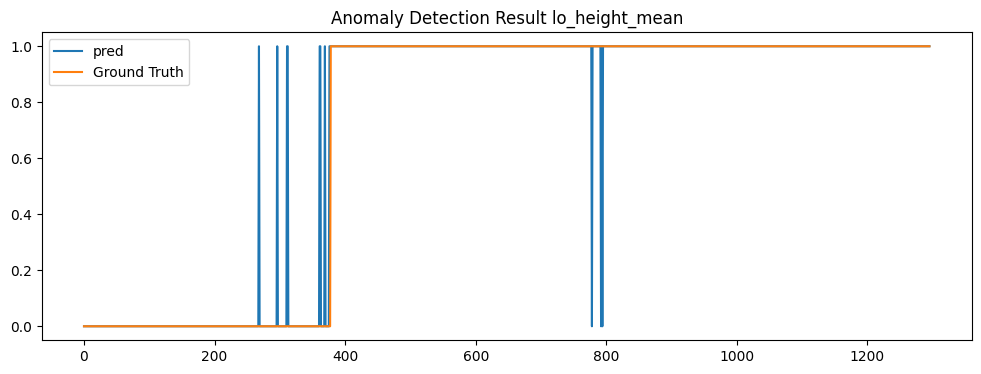

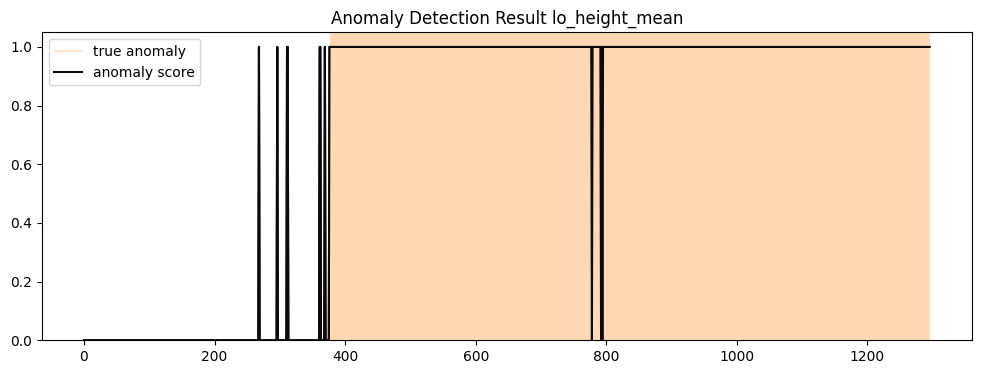

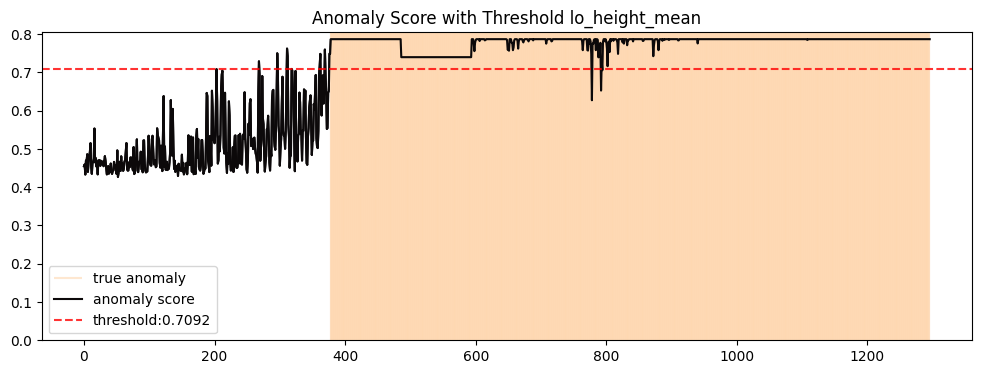

lo_area
model Fitted
Inference Completed
AUROC: 0.9222, F1: 0.9028, Precision: 0.8899, Recall: 0.9161
Confusion Matrix: (274, 104, 77, 841)


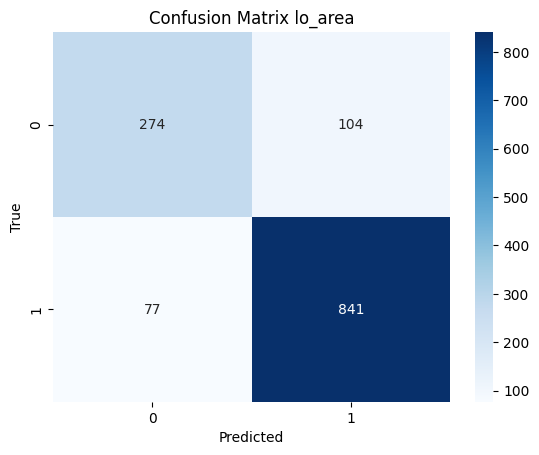

[{False: 14, True: 40}, {True: 42, False: 12}, {False: 40, True: 14}, {False: 50, True: 4}, {True: 3, False: 51}, {False: 53, True: 1}, {False: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 35, False: 19}, {False: 1, True: 53}, {True: 50, False: 4}, {True: 12, False: 42}, {False: 2, True: 52}, {True: 54}, {True: 50, False: 4}, {True: 49, False: 5}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}]


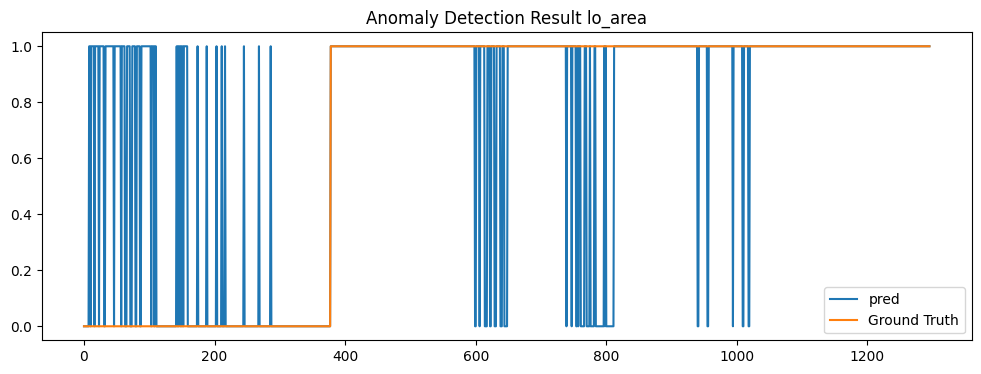

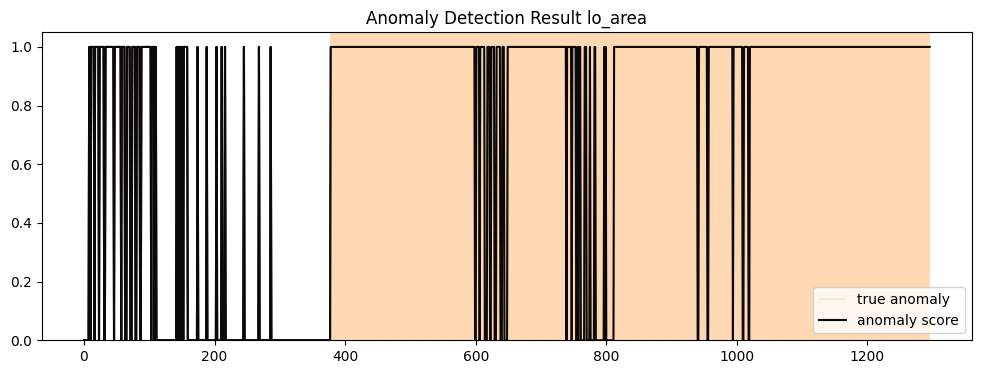

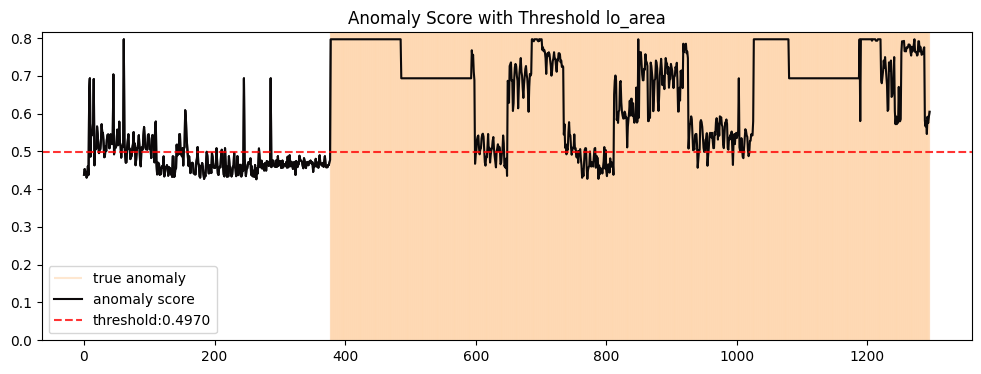

br_diff_peak
model Fitted
Inference Completed
AUROC: 0.7178, F1: 0.8297, Precision: 0.7101, Recall: 0.9978
Confusion Matrix: (4, 374, 2, 916)


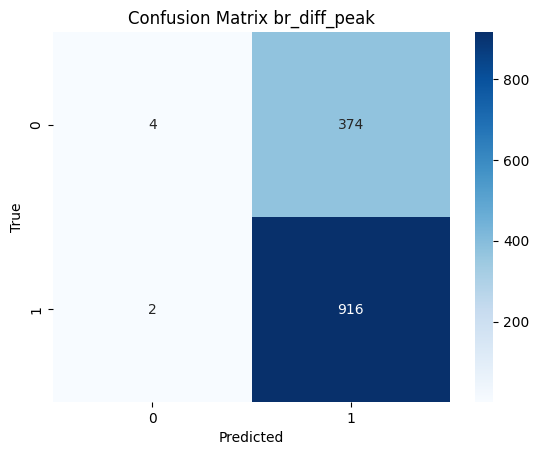

[{True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}]


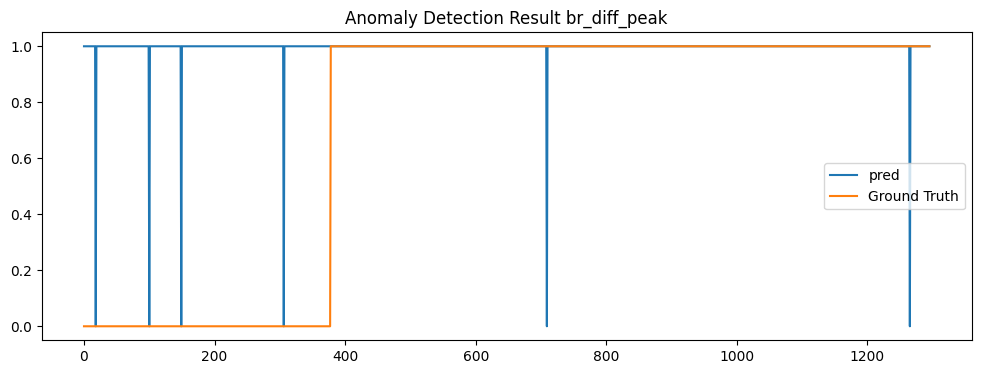

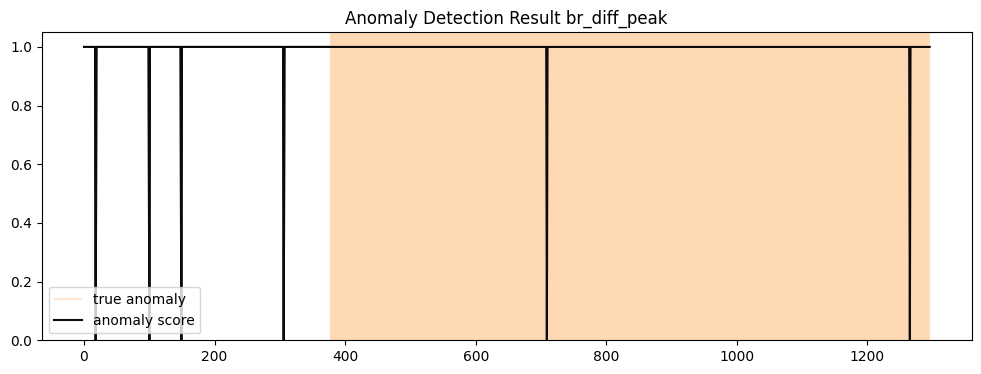

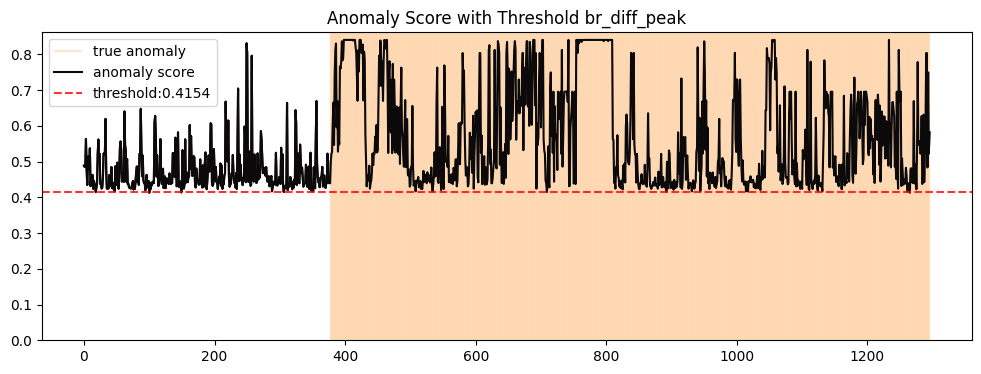

vis_reach_time
model Fitted
Inference Completed
AUROC: 0.7597, F1: 0.8277, Precision: 0.7116, Recall: 0.9891
Confusion Matrix: (10, 368, 10, 908)


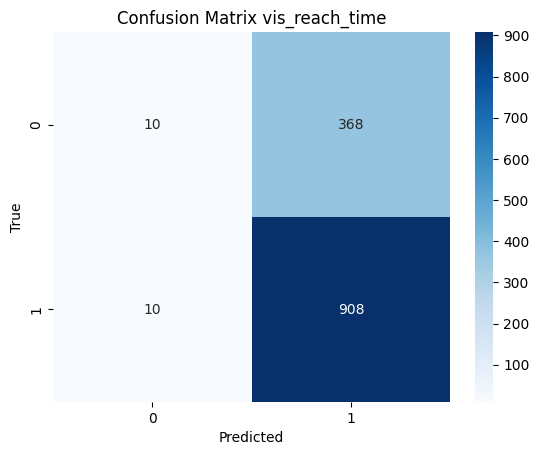

[{True: 54}, {True: 52, False: 2}, {True: 51, False: 3}, {True: 53, False: 1}, {True: 52, False: 2}, {True: 52, False: 2}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 51, False: 3}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 51, False: 3}, {True: 54}, {True: 53, False: 1}]


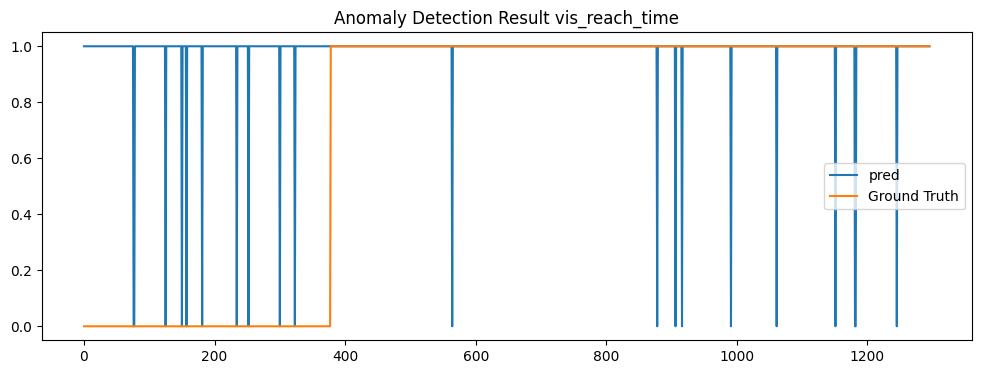

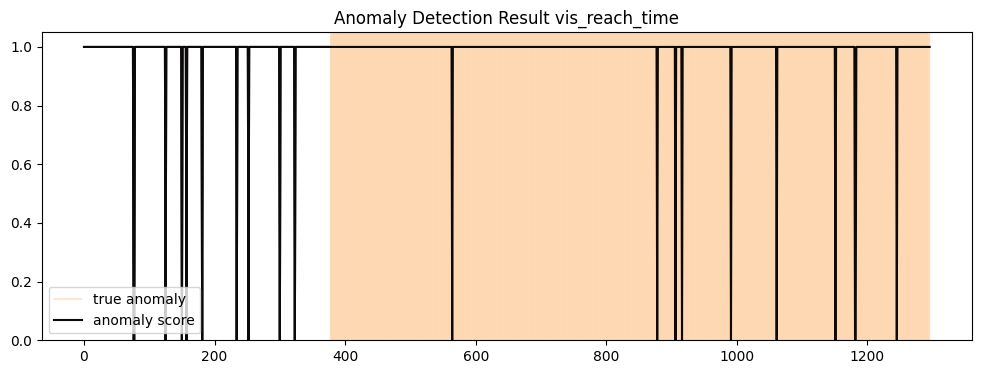

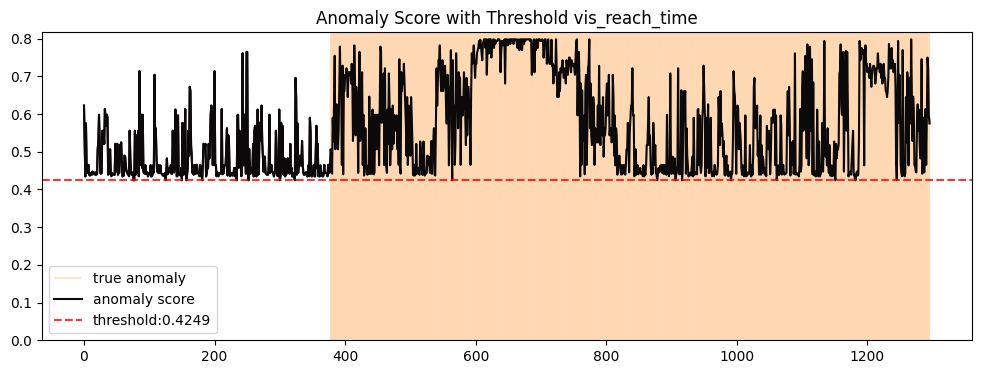

In [16]:
df_metrics = pd.DataFrame()
df_bead_counter = pd.DataFrame()

for idx, name in enumerate(selected_features):

    print(name)

    IF = modelling(model, dataset, name, random_state = 72)

    IF.fit()

    metrics_ = IF.get_metrics()
    confusion_mat = IF.get_confusion_mat()

    temp = pd.DataFrame(metrics_.values()).T
    temp.columns = list(metrics_.keys())

    df_metrics = pd.concat([df_metrics, temp], axis = 0)

    bead_counter_ = IF.bead_count()
    
    temp_df = pd.DataFrame(bead_counter_).fillna(0)
    temp_df['feature_name'] = name

    df_bead_counter = pd.concat([df_bead_counter, temp_df], axis = 0)


    IF.plot_result()

df_metrics.index = selected_features
df_metrics = df_metrics.T
df_bead_counter = df_bead_counter[['feature_name', 0, 1]]
df_bead_counter.columns = ['feature_name', 'Normal', 'Abnormal']

In [19]:
df_bead_counter

,feature_name,Normal,Abnormal
0,nir_peak,44.0,10.0
1,nir_peak,39.0,15.0
2,nir_peak,45.0,9.0
3,nir_peak,40.0,14.0
4,nir_peak,43.0,11.0
...,...,...,...
19,vis_reach_time,28.0,26.0
20,vis_reach_time,28.0,26.0
21,vis_reach_time,28.0,26.0
22,vis_reach_time,1.0,53.0


In [20]:
df_metrics

,nir_peak,nir_reach_time,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,lo_height_mean,lo_area,br_diff_peak,vis_reach_time
AUROC,0.594035,0.662733,0.508170,0.568017,0.489424,0.668753,0.997362,0.922247,0.717781,0.759656
F1,0.828799,0.822502,0.032154,0.782129,0.825983,0.831211,0.993480,0.902840,0.829705,0.827707
Precision,0.709302,0.708991,0.999999,0.718323,0.708496,0.712286,0.990260,0.889947,0.710078,0.711599
Recall,0.996732,0.979303,0.016340,0.858388,0.990196,0.997821,0.996732,0.916122,0.997821,0.989107
